In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## 1. Data Loading & Preprocessing

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

mask_train = (train_labels == 2) | (train_labels == 6)
mask_test  = (test_labels  == 2) | (test_labels  == 6)

X_train = train_images[mask_train].reshape(-1, 784).astype('float32') / 255.0
X_test  = test_images[mask_test].reshape(-1, 784).astype('float32')  / 255.0

y_train = np.where(train_labels[mask_train] == 2, -1, 1)
y_test  = np.where(test_labels[mask_test]   == 2, -1, 1)

print(f'Train: {X_train.shape}, Test: {X_test.shape}')

       0/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

   90112/11490434 ━━━━━━━━━━━━━━━━━━━━ 6s 1us/step

  573440/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

 2285568/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

 5136384/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

 5619712/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

 5799936/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

 8290304/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

 8904704/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

 9478144/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

10018816/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

10625024/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

11132928/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Train: (11876, 784), Test: (1990, 784)


## 2. Feature Augmentation (Bias Term)

In [3]:
X_train_b = np.column_stack((np.ones(len(X_train)), X_train))
X_test_b  = np.column_stack((np.ones(len(X_test)),  X_test))

print(f'Augmented feature dim: {X_train_b.shape[1]} (784 pixels + 1 bias)')

Augmented feature dim: 785 (784 pixels + 1 bias)


## 3. Model Definition

In [4]:
def predict(w, X):
    return np.where(X @ w >= 0, 1, -1)

def zero_one_loss(y_true, y_pred):
    return np.mean(y_true != y_pred)

## 4. Perceptron Training Algorithm

In [5]:
def train_perceptron(X, y, alpha=0.15, target_acc=95.0, max_epochs=100):
    w = np.zeros(X.shape[1])
    history = []

    for epoch in range(max_epochs):
        for i in range(len(X)):
            if predict(w, X[i:i+1])[0] != y[i]:
                w += alpha * y[i] * X[i]

        acc = (1 - zero_one_loss(y, predict(w, X))) * 100
        history.append(acc)

        if acc >= target_acc:
            return w, epoch + 1, history

    return w, max_epochs, history


w_95, epochs_95, hist_95 = train_perceptron(X_train_b, y_train, target_acc=95.0)
w_80, epochs_80, hist_80 = train_perceptron(X_train_b, y_train, target_acc=80.0)

print(f'95% target: converged in {epochs_95} epoch(s)')
print(f'80% target: converged in {epochs_80} epoch(s)')

95% target: converged in 1 epoch(s)
80% target: converged in 1 epoch(s)


## 5. Evaluation (0-1 Loss)

In [6]:
results = {}
for label, w, epochs in [('95% stopping', w_95, epochs_95), ('80% stopping', w_80, epochs_80)]:
    tl = zero_one_loss(y_train, predict(w, X_train_b))
    vl = zero_one_loss(y_test,  predict(w, X_test_b))
    results[label] = {'train_loss': tl, 'test_loss': vl, 'epochs': epochs}
    print(f'{label:<16} | Epochs={epochs:>3} | Train Loss={tl:.4f} | Test Loss={vl:.4f}')

95% stopping     | Epochs=  1 | Train Loss=0.0194 | Test Loss=0.0186
80% stopping     | Epochs=  1 | Train Loss=0.0194 | Test Loss=0.0186


## 6. Visualization

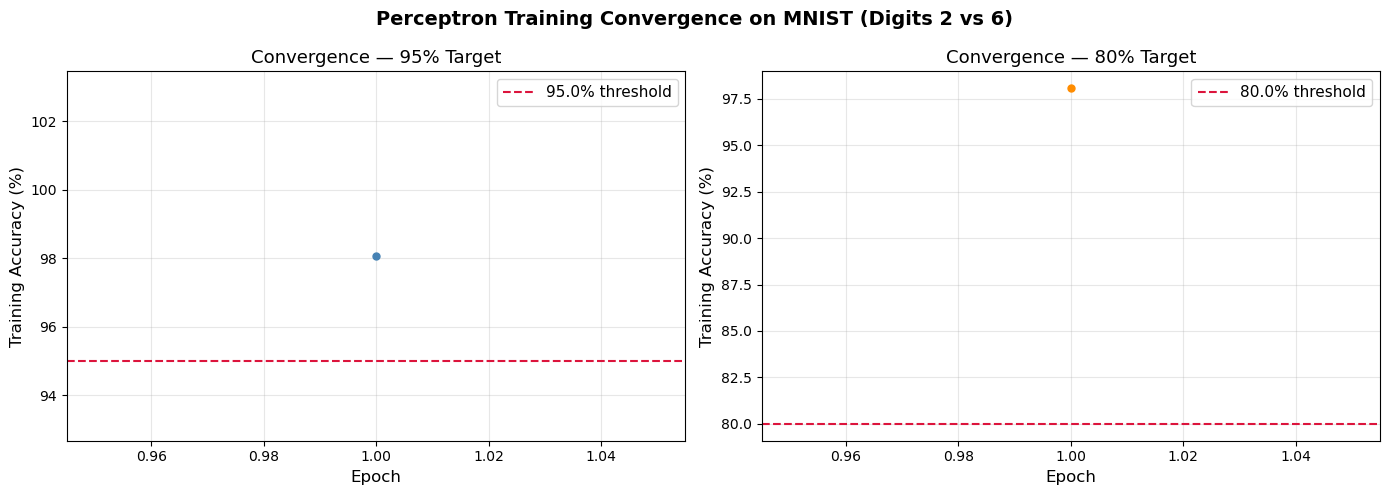

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (hist, target, color, title) in zip(axes, [
    (hist_95, 95.0, 'steelblue',  'Convergence — 95% Target'),
    (hist_80, 80.0, 'darkorange', 'Convergence — 80% Target'),
]):
    ax.plot(range(1, len(hist) + 1), hist, '-o', color=color, markersize=5, linewidth=2)
    ax.axhline(y=target, color='crimson', linestyle='--', linewidth=1.5, label=f'{target}% threshold')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Training Accuracy (%)', fontsize=12)
    ax.set_title(title, fontsize=13)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

plt.suptitle('Perceptron Training Convergence on MNIST (Digits 2 vs 6)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/perceptron_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

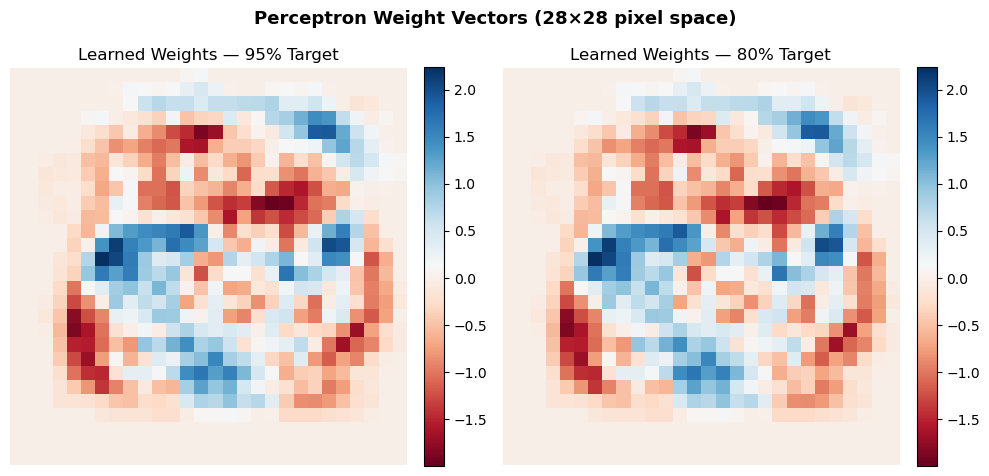

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for ax, (w, title, cmap) in zip(axes, [
    (w_95, 'Learned Weights — 95% Target', 'RdBu'),
    (w_80, 'Learned Weights — 80% Target', 'RdBu'),
]):
    im = ax.imshow(w[1:].reshape(28, 28), cmap=cmap, interpolation='nearest')
    ax.set_title(title, fontsize=12)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle('Perceptron Weight Vectors (28×28 pixel space)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('results/perceptron_weights.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Results Summary

In [9]:
header = '{:<20} {:>8} {:>16} {:>14}'.format('Model','Epochs','Train 0-1 Loss','Test 0-1 Loss')
print(header)
print('-' * 62)
for label, r in results.items():
    print('{:<20} {:>8} {:>16.4f} {:>14.4f}'.format(label, r['epochs'], r['train_loss'], r['test_loss']))

Model                  Epochs   Train 0-1 Loss  Test 0-1 Loss
--------------------------------------------------------------
95% stopping                1           0.0194         0.0186
80% stopping                1           0.0194         0.0186
